This notebook demonstrates typical usages of the `InConstraintSolver` in `QVoice`.

First, set the number of variables/qubits and the seed for generating the problem

In [1]:
n = 10
seed = 42

Define a problem with `qiskit_optimization`, `qiskit_finance`, or `docplex.mp`

In [2]:
import networkx as nx
from qiskit_optimization.applications import GraphPartition

problem = GraphPartition(
        nx.random_partition_graph([n // 2] * 2, 1, 2 / n, seed)
    ).to_quadratic_program()

# from qiskit_finance.applications.optimization import PortfolioOptimization
# problem = PortfolioOptimization(...).to_quadratic_program()

Or even easier, get a random instance of a supported problem from `qvoice.problems`

In [3]:
from qvoice.problems import (
    portfolio_optimization,
    vertex_cover,
    clique,
    graph_partition,
    independent_set,
    max_bisection
)

problem = portfolio_optimization.get_random_instance(n, seed)

Print out the problem formulation

In [4]:
print(problem.prettyprint())

Problem name: Portfolio optimization

Minimize
  5.7796487510886654e-05*x_0^2 - 2.4659889669429102e-05*x_0*x_1
  - 1.4540878242199584e-05*x_0*x_2 + 7.707682731796285e-05*x_0*x_3
  - 8.440798780779955e-05*x_0*x_4 + 0.0014246970164437387*x_0*x_5
  + 6.3512115437365565e-06*x_0*x_6 + 3.0960933633768985e-05*x_0*x_7
  + 3.0011656650228327e-05*x_0*x_8 - 1.087666660155373e-05*x_0*x_9
  + 4.959665110936531e-05*x_1^2 + 2.7125868440010675e-05*x_1*x_2
  - 2.1314298417136948e-05*x_1*x_3 + 1.3155621054003469e-05*x_1*x_4
  + 4.562924374179454e-05*x_1*x_5 - 4.900081104393936e-05*x_1*x_6
  - 2.4678406566148494e-06*x_1*x_7 - 2.5287454873748464e-05*x_1*x_8
  - 6.30479226746691e-05*x_1*x_9 + 2.742900931639314e-05*x_2^2
  - 4.130239036044618e-05*x_2*x_3 + 6.491177784469777e-05*x_2*x_4
  + 0.0022275555565701177*x_2*x_5 + 7.377304659778573e-06*x_2*x_6
  + 1.8539011238610875e-05*x_2*x_7 - 4.2600817447114005e-05*x_2*x_8
  + 3.183916570846658e-08*x_2*x_9 + 0.002635168726691646*x_3^2
  + 0.00014015587139391939*x

Define the VQA algorithm with `qiskit` as usual

In [5]:
import qvoice
from qiskit_aer import AerSimulator
from qiskit.algorithms import VQE, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal


reps = 1
maxiter = 300
optimizer = COBYLA(maxiter=maxiter, disp=True)
backend = AerSimulator(method="statevector")

algorithm = VQE(
    TwoLocal(n, "ry", "cz", reps=reps, entanglement="linear"),
    optimizer=optimizer,
    quantum_instance=backend,
)
# or
algorithm = QAOA(
    reps=1,
    optimizer=optimizer,
    quantum_instance=backend,
)

The `InConstraintSolver` can be constructed with one line of code using normal `qiskit` problem and VQA objects: 
```
solver = qvoice.InConstraintSolver(algorithm, problem)
```

It also can be fine-tuned with several options. 
- `in_cons_prob_lbound` specifies the lower bound constraint for the in-constraint probability. Default is `None`.
- `penalty` defines the penalty factor that controls the penalty term in the Hamiltonian. Default is `None`, which uses `qiskit_optimization`'s penalty heuristic: `qiskit_optimization.converters.LinearEqualityToPenalty()._auto_define_penalty(problem)`.
- `use_in_cons_energy` can be set to `False` to use the normal penalized energy approach while still having metrics logged during the optimization process. Default is `True`.
- `log_level` tells the solver what metrics to compute and log at each iteration. Higher `log_level` gives more information but also leads to greater overheads. Note that for some solver settings, certain metrics need to be computed regardless of how `log_level` specifies. Default is 0.
    - `log_level=0` Nothing
    - `log_level=1` energy
    - `log_level=2` in-constraint probability
    - `log_level=3` approximation ratio and optimal solution probability

In [7]:
in_cons_prob_lbound = 0.05
penalty = None
solver = qvoice.InConstraintSolver(
    algorithm,
    problem,
    penalty=penalty,
    use_in_cons_energy=True,
    in_cons_prob_lbound=in_cons_prob_lbound,
    log_level=3,
)
print(solver.solve())

Optimal Solution:  1100001101
Approximation ratio of random guess:  0.4898208778998014

   Normal return from subroutine COBYLA

   NFVALS =   45   F =-5.833260E+00    MAXCV = 0.000000E+00
   X = 7.954024E-01   3.281358E+00
Iterations:  45
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 45,
    'eigenstate': array([ 0.00056654-0.00557194j, -0.01800237+0.01452369j,
       -0.01779661+0.01412112j, ..., -0.03810839-0.03563441j,
       -0.03751676-0.0358479j , -0.19143356-0.0999034j ]),
    'eigenvalue': (-5.833259770403234+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(β[0]): 0.7954023795751415,
                              ParameterVectorElement(γ[0]): 3.2813581481822442},
    'optimal_point': array([0.79540238, 3.28135815]),
    'optimal_value': -5.833259770403234,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 15.665207624435425}


Plot the logged metrics and the grid search overlaid with the optimizer trace.

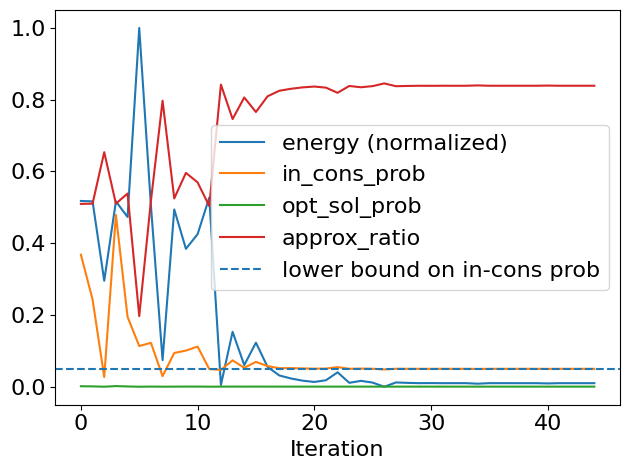

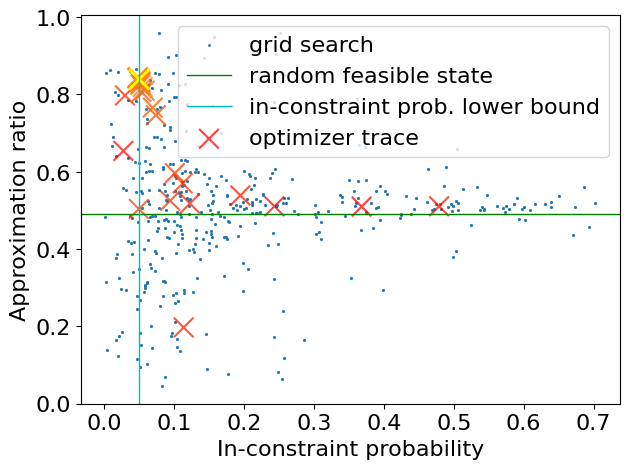

In [9]:
solver.plot_log()

beta_steps, gamma_steps = 30, 30
solver.plot_pareto_frontier(
    beta_steps=beta_steps,
    gamma_steps=gamma_steps,
)
